# Texture Normal Mapping

## SCC0251.2020.1 - Image Processing

Prof. Dr. Moacir Ponti

Renata Vinhaga dos Anjos (10295263) and Vitor Gratiere Torres (10284952)

### Description

#### How lights are calculated for surfaces?

Before understanding what a Normal Map is, first we need to describe how Computer Graphics decides the final color for each pixel of a 3D Object. There are a lot of information stored in each vertex, from positions in 3D space to colors. Those vertices build faces, and those faces will have a fragment color, depending on the interpolation of the vertices’ colors.

But we must remember that, in the real world, there are a bunch of elements beyond the natural color of a surface that determines its visual look. One of them is the light influence.

One single light source next to an object will affect the intensity of faces colors, according to each ** normal**. Some calculation is done with the light rays, the normal, and the viewer position, as it is demonstrated in the Image below.

![image](https://learnopengl.com/img/lighting/basic_lighting_specular_theory.png)

For our main purpose, is necessary to understand that, each face of a 3D Object has a normal, and as it is flat, all the fragments of this face will be affected in the same way as they have the same normal. Even if it has a complex texture.
With more complex 3D meshes (big number of vertices), than the object will have more faces and consequently a bigger variance for the light calculation. But bigger meshes also means more computation, and time is something that needs to be spent wisely in Computer Graphics.

To solve this problem, we put our efforts in this project to understand how the Normal Map works and how we could implement it.

#### But what are Normal Maps?

The normal map is, as the name implies, a mapping for the normals of a surface. As it is explained in the follow image, instead of having a single normal for all the fragments of a flat surface, what we will have is a per fragment ("per pixel") different normal.

![image](https://learnopengl.com/img/advanced-lighting/normal_mapping_surfaces.png)

The brutal difference for it can be seen in the comparison below:

![image](https://learnopengl.com/img/advanced-lighting/normal_mapping_compare.png)

The geometric normal of the surface remains the same, we merely modify the surface normal used in the lighting calculation [11] (as showed before). Just as having a normal per vertex gives the illusion that the surface is smooth between polygons, modifying the normal per pixel changes the perception of the polygon surface itself, without modifying its geometry.
We can see an example of the benefits for it in the image below. The use of a normal map provides that the meshes can be simplified and have the same visual look as a more complex mesh.

![image](https://learnopengl.com/img/advanced-lighting/normal_mapping_comparison.png)

#### The look of a normal map and how it works

To store a normal per pixel, we use each channel of a RGB image to store the magnitude of 3 vectors (X, Y, Z) respectively. In that way, the combination of those 3 will result in a "direction" of the surface, without really changing the aspect of it.

The look of a usual normal map can be seen in the image below:

![image](https://docs.unity3d.com/uploads/Main/BumpMapColourMapStoneWallExample.jpg)

This blueish color can be seen in every normal map and it has a reason that can be explained by the Tangent Space.

#### Tangent Space

When we are dealing with computer graphics, that is a lot to understand about different spaces to deal with the object. As example we can take the Object Space and the World Space. 

When we consider the object in the world space, it will have a lot of orientations in its faces, considering the 3D space, those can be either negative or positive, in the case of the z-axis for example.

But when we are dealing with a normal map took from a texture, we only have 2 types of orientation: the X and Y, while the Z will always be pointing outwards. Because of that, normal maps tend to have this blueish color, once that Z is equivalent to the blue channel, and it will always be positive.

Making calculations only with the surface orientation makes everything easier, as we know for sure the orientation of one of the coordinates (the Z). The images below show the differences between a map of normals done via World Space (Left) and Local Space or Tangent Space (Right). In the left, we can see more colors than blueish ones, that's because world space allows negative orientation for Z as seen below, the backside of the boot according to the camera is on the negative region of z, that means negative or absence of blue, generating colors like this yellow green.

![](https://docs.cryengine.com/download/attachments/1605679/OSTS1.jpg?version=1&modificationDate=1251809719000&api=v2)

![](https://docs.cryengine.com/download/attachments/1605679/OSTS0.jpg?version=1&modificationDate=1251809751000&api=v2)

#### Implementing the Normal Map from Textures
The normal map can be extracted and made from any texture or image. There are a several ways to do that, and one of them is related to Image Processing. The following code is done step by step to process the texture in order to obtain better results. Then we use a filter for Edge Detection called Sobel Operator, that helps us to get the right color strength information to store within the normal map.

The user interface also provides parameters changes, in order to get the desired normal map.

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# ^ Interact imports

import imageio
import matplotlib.pyplot as plt
import numpy as np
import re

__author__ = ['Renata Vinhaga', 'Vitor Gratiere']

In [2]:
# Our storage structure

data = {
    'settings': {
        'filepath': None,
        'strength': 2.5,
        'level': 7.0,
        'blur': False,
        'R': False,
        'G': False,
        'img_shape': None,
        'original_dim': None,
        'save': False,
    },
    'images': {
        'original': None,
        'gray': None,
        'blur': None,
        'normal': None,
        'sobel': None,
    },
}

In [3]:
data['settings']['filepath'] = str(input()).rstrip()
# take a texture image as input

data['images']['original'] = imageio.imread(data['settings']['filepath'])
data['images']['original'] = np.asarray(
    data['images']['original'], dtype=float)

# We store image's width, height and its dimension
data['settings']['img_shape'] = np.array(data['images']['original'].shape)
data['settings']['original_dim'] = np.array(
    data['settings']['img_shape'].shape)[0]
data['settings']['img_shape'] = data['settings']['img_shape'][:2]

/home/ava/documents/documents/classes/nm/NormalMapping/images/eye.jpeg


In [4]:
def map_values(image, newMin=0, newMax=255):
    """Maps matrix's values from [`originalMin`, `originalMax`] to [`newMin`, `newMax`]"""
    a = np.min(image)
    b = np.max(image)
    return ((image - a) * ((newMax - newMin) / (b - a)) + newMin)


def map_values_rgb(image, newMin=0, newMax=255):
    """Applies `map_values` to each channel on RGB separetedly"""
    for i in range(0, 3):
        image[:, :, i] = map_values(image[:, :, i],
                                    newMin=newMin,
                                    newMax=newMax)
        return image

#### Step 1 - Convert image to Gray Scale

One of the details that we discovered to get better results is that,
first, we need to convert the texture for a gray scale image (if it is in
RGB system). In this way, the range of values is smaller, so the change
of them is more visible.

In [5]:
def rgb_to_gray(rgb):
    """Converts coloured image to gray scale"""
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = np.zeros(np.array(rgb.shape)[0:2])
    # gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return gray

In [6]:
if data['settings']['original_dim'] == 3:
    data['images']['gray'] = rgb_to_gray(data['images']['original'])
elif data['settings']['original_dim'] == 2:
    data['images']['gray'] = data['images']['original']
else:
    raise ValueError('We can only handle 2 and 3 dimensions matrices.')

(-0.5, 563.5, 563.5, -0.5)

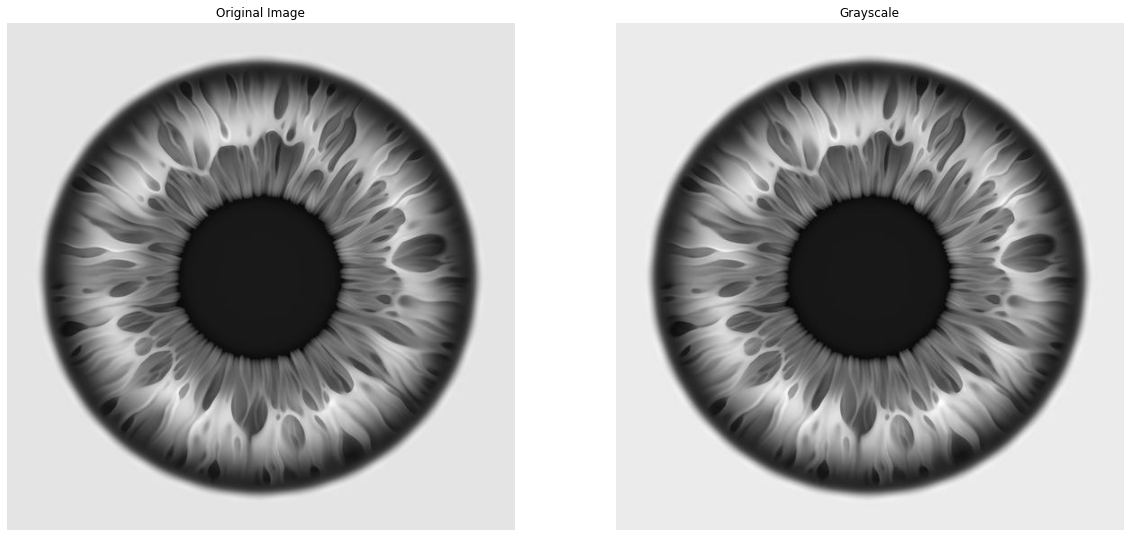

In [7]:
plt.figure(figsize=(20, 20))

plt.subplot(121)
plt.imshow(data['images']['original'].astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(data['images']['gray'].astype(np.uint8), cmap="gray")
plt.title('Grayscale')
plt.axis('off')

#### [Optional] Step 2 - Blurring the image

The Sobel Operator is a very sensitive filter and any noise can render a low-quality light reflection diminishing the aesthetic of the final render, Gaussian Filter's blur can help us, but for this example we will not use it, but you can activate it if you want to.

In [8]:
def gaussian_filter(image, kernelWidth=3, sigma=150):
    """Convolutes a Gaussian Filter to blur the image"""

    def e(x, y):
        """Euclidean distance between `x` and `y`"""
        return np.sqrt(x**2 + y**2)

    def kernel(x, s):
        """Gaussian Kernel at `x`"""
        return np.exp((-(x**2)) / (2 * (s**2))) / (2 * np.pi * (s**2))

    # padding lenght
    pad = int(np.floor(kernelWidth / 2))

    # original image dimensions
    ix, iy = image.shape

    # final image
    ans = np.array([[0.0 for y in range(0, iy)] for x in range(0, ix)])

    # range to create spatial kernel component
    # it creates ranges like [-2, -1, 0, 1, 2] for n == 5
    nrng = range(int(np.ceil(-kernelWidth / 2)), int(np.ceil(kernelWidth / 2)))

    # spatial kernel component
    sgc = np.array([[kernel(e(x, y), sigma) for y in nrng] for x in nrng])

    # padding
    image = np.pad(image, pad, 'constant').astype(np.float)

    # for each index in image avoiding the pad
    for i in range(pad, ix + pad):
        for j in range(pad, iy + pad):

            # range kernel component for each neighborhood
            # it subtracts the middle value from each valeu in the neighborhood
            # and applies it to the kernel, and creates a new matrix, rgc
            rgc = np.array([[kernel(image[x, y] - image[i, j], sigma)
                             for y in range(j - pad, j + pad + 1)]
                            for x in range(i - pad, i + pad + 1)])
            w = np.multiply(rgc, sgc)
            # multiplies windowed image and w, sums each point
            # than devides by the sum of w
            ans[i - pad,
                j - pad] = np.sum(np.multiply(image[i - pad:i + pad + 1,
                                                    j - pad:j + pad + 1],
                                              w)) / np.sum(w)
    return ans

In [9]:
def apply_blur(blur):

    if blur is not data['settings']['blur']:
        data['settings']['blur'] = blur

        if data['settings']['blur']:

            data['images']['blur'] = gaussian_filter(
                data['images']['gray'], 5, 250)

            plt.figure(figsize=(20, 20))

            plt.subplot(121)
            plt.imshow(data['images']['gray'].astype(np.uint8), cmap="gray")
            plt.title('Grayscale')
            plt.axis('off')

            plt.subplot(122)
            plt.imshow(data['images']['blur'].astype(np.uint8), cmap="gray")
            plt.title('Blurred grayscale')
            plt.axis('off')


interact(apply_blur, blur=data['settings']['blur'])

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.apply_blur(blur)>

#### Step 3 - Sobel-Feldman operator

Sobel-Feldman operator is an edge detector, it uses two 3×3 kernels which are convolved with the original image to calculate approximations of the derivatives – one for horizontal changes, and one for vertical. If we define $A$ as the source image, and $Gx$ and $Gy$ are two images which at each point contain the vertical and horizontal derivative approximations respectively, the computations are as follows:

$$G_x = \begin{bmatrix}-1 & 0 & 1\\-2 & 0 & 2\\-1 & 0 & 1\end{bmatrix}$$

$$G_y = \begin{bmatrix}-1 & -2 & -1\\0 & 0 & 0\\1 & 2 & 1\end{bmatrix}$$

Then we will crop $A$ matrix to fit kernel's shape, iterate and convolute it.

> It is also possible to use $G_x$ and $G_y$ with 3s instead of 1s, and 10s instead of 2s, it's just a matter of factors and scales. 1s and 2s got us our best outcome so far.

The x-coordinate is defined here as increasing in the "right"-direction, and the y-coordinate is defined as increasing in the "down"-direction. At each point in the image, the resulting gradient approximations can be combined to give the gradient magnitude, using $G = \sqrt{G_x^2 + G_y^2}$. Using this information, we can also calculate the gradient's direction as $\theta = atan\left(\frac{G_y}{G_x}\right)$, this angle $\theta$ tells us the light's angle, while the $G$ vector is the light's vector itself.

The components $G_x$ and $G_y$ divided by its' square root gives us the unitary components.

The $x$ component will be depicted as our reds, while the $y$ as our greens. Our blue component comes from the two parameters: `strength` and `level`, so it represents how much the normal map will be bumped. All of them are scaled to $0-255$. 

In [10]:
def sobel(img, strength=2.5, level=7.0):
    Gx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    Gy = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])
    # The other possible kernel
    # Gx = np.array([[-3, 0, 3],
    #                [-10, 0, 10],
    #                [-3, 0, 3]])
    # Gy = np.array([[-3, -10, -3],
    #                [0, 0, 0],
    #                [3, 10, 3]])

    shp = np.array(img.shape)[0:2]
    img = np.pad(img, 1, 'edge')
    sob = np.zeros(shp)
    normal_map = np.zeros(np.array([shp[0], shp[1], 3]))
    dZ = 1.0 / strength * (1.0 + (2.0 ** level))
    dZ_pow = dZ * dZ
    for i in range(0, shp[0]):
        for j in range(0, shp[1]):
            dX = np.sum(np.multiply(Gx, img[i:i + 3, j:j + 3]))
            dY = np.sum(np.multiply(Gy, img[i:i + 3, j:j + 3]))
            sob[i, j] = np.sqrt(dX**2 + dY**2 + dZ_pow)
            normal_map[i, j, 0] = (dX / sob[i, j] * 0.5 + 0.5) * 255.0  # red
            normal_map[i, j, 1] = (dY / sob[i, j] * 0.5 + 0.5) * 255.0  # green
            normal_map[i, j, 2] = dZ / sob[i, j] * 255.0  # blue
    sob = map_values(sob)
    normal_map = map_values_rgb(normal_map)
    return normal_map, sob

In [11]:
def apply_sobel(strength=data['settings']['strength'],
                level=data['settings']['level']):

    data['settings']['strength'] = strength
    data['settings']['level'] = level

    if data['settings']['blur']:
        data['images']['normal'], data['images']['sobel'] = sobel(
            data['images']['blur'], data['settings']['strength'], data['settings']['level'])
    else:
        data['images']['normal'], data['images']['sobel'] = sobel(
            data['images']['gray'], data['settings']['strength'], data['settings']['level'])

    plt.figure(figsize=(20, 20))

    plt.subplot(131)
    plt.imshow(data['images']['original'].astype(np.uint8))
    plt.title('Original image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(data['images']['normal'].astype(np.uint8))
    plt.title('Normal map')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(data['images']['sobel'].astype(np.uint8), cmap='gray')
    plt.title('Edges detected by sobel operator')
    plt.axis('off')

    plt.show()


interact(apply_sobel,
         strength=(0.01, 5.00, 0.01),
         level=(4.0, 10.0, 0.1))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.apply_sobel(strength=2.5, level=7.0)>

#### Step 4 - Inverting channels

It is possible that your image output looks weird, it may be that your channels are inverted, making concave looks convex. So, we got to be able to invert single channels.

In [12]:
def inv(img):
    """Invert images"""
    return 255 - img

In [13]:
def invert(red, green):
    if red is not data['settings']['R']:
        data['settings']['R'] = red
        data['images']['normal'][:, :, 0] = inv(
            data['images']['normal'][:, :, 0])
    if green is not data['settings']['G']:
        data['settings']['G'] = green
        data['images']['normal'][:, :, 1] = inv(
            data['images']['normal'][:, :, 1])

    plt.figure(figsize=(20, 20))

    plt.subplot(141)
    plt.imshow(data['images']['normal']
               [:, :, 0].astype(np.uint8), cmap="Reds")
    plt.title('Red channel of normal map')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(data['images']['normal']
               [:, :, 1].astype(np.uint8), cmap="Greens")
    plt.title('Green channel of normal map')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(data['images']['normal']
               [:, :, 2].astype(np.uint8), cmap="Blues")
    plt.title('Blue channel of normal map')
    plt.axis('off')

    plt.subplot(144)
    plt.imshow(data['images']['normal'].astype(np.uint8))
    plt.title('Normal map')
    plt.axis('off')

    plt.show()


interact(invert, red=data['settings']['R'], green=data['settings']['G'])

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.invert(red, green)>

#### Saving the resulting image

In [14]:
def save_f(save):
    if save is not data['settings']['save']:
        data['settings']['save'] = save

    if data['settings']['save']:
        # Original file path + file name
        output = data['settings']['filepath'][:data['settings']
                                              ['filepath'].find('.')]

        # Append strength value to image's title
        output += '_S' + \
            ("{:.1f}".format(data['settings']['strength'])).replace('.', '-')

        # Append level value to image's title
        output += '_L' + \
            ("{:.1f}".format(data['settings']['level'])).replace('.', '-')

        # Blur descriptor
        if data['settings']['blur']:
            output += '_blr'

        # Colors and inversions descriptor
        output += '_'
        if data['settings']['R']:  # If R channel is inverted append r, else R
            output += 'r'
        else:
            output += 'R'

        if data['settings']['G']:  # If G channel is inverted append g, else G
            output += 'g'
        else:
            output += 'G'

        # File type
        output += '.png'

        imageio.imwrite(output, data['images']['normal'].astype(np.uint8))
        # imageio.get_writer(output).close()
        print(output)

        plt.figure(figsize=(20, 20))
        plt.imshow(data['images']['normal'].astype(np.uint8))
        plt.title('Normal map')
        plt.axis('off')
        plt.show()


interact(save_f, save=data['settings']['save'])

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.save_f(save)>

#### Applied results

We crafted a simple setting to test our results in open-source 3D computer graphics software Blender, it has a plane with only 4 vertices and 1 face, simple as it is. To its' material we have applied our normal map. We also defined a camera (for rendering purposes) and a spotlight, this light will give a full $2\pi$ turn around the z-axis.

![](https://raw.githubusercontent.com/vitorgt/NormalMapping/master/images/blender_screen2.gif)

The light on the flat surface reflects accordingly to the normal map.

![](https://raw.githubusercontent.com/vitorgt/NormalMapping/master/images/eye_rendered.gif)

#### Bibliography

##### Normal Map

[1] https://en.wikipedia.org/wiki/Lambertian_reflectance

[2] https://cpetry.github.io/NormalMap-Online/

[3] https://www.quora.com/How-are-normal-maps-made

[4] https://stackoverflow.com/questions/13983189/opengl-how-to-calculate-normals-in-a-terrain-height-grid/13983431#13983431

[5] https://en.wikipedia.org/wiki/Von_Neumann_neighborhood

[6] https://azgaar.wordpress.com/2018/02/26/image-converter/

[7] https://en.wikipedia.org/wiki/Sobel_operator

[8] http://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm

[9] https://docs.unity3d.com/Manual/StandardShaderMaterialParameterNormalMap.html

[10] K. Engel (2006). Real-time volume graphics.

[11] Moller, Haines and Naty. Real-Time Rendering (Third Edition)

##### Bump Map

https://web.archive.org/web/20060924191232/http://freespace.virgin.net/hugo.elias/graphics/x_polybm.htm

##### Canny Edge Detection

https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

https://towardsdatascience.com/implement-canny-edge-detection-from-scratch-with-pytorch-a1cccfa58bed

https://www.researchgate.net/publication/258225507_Edge_Detection_on_Polynomial_Texture_Maps

https://en.wikipedia.org/wiki/Canny_edge_detector

##### Edge Detection

https://en.wikipedia.org/wiki/Edge_detection

##### Image Links
https://learnopengl.com/img/lighting/basic_lighting_specular_theory.png

https://learnopengl.com/img/advanced-lighting/normal_mapping_surfaces.png

https://learnopengl.com/img/advanced-lighting/normal_mapping_compare.png

https://learnopengl.com/img/advanced-lighting/normal_mapping_comparison.png

https://docs.unity3d.com/uploads/Main/BumpMapColourMapStoneWallExample.jpg

https://docs.cryengine.com/download/attachments/1605679/OSTS1.jpg?version=1&modificationDate=1251809719000&api=v2

https://docs.cryengine.com/download/attachments/1605679/OSTS0.jpg?version=1&modificationDate=1251809751000&api=v2